In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
%matplotlib inline

<h2>Sample train & test data</h2>

In [2]:
# PAGE 16. First we generated 10 means mk from a bivariate Gaussian
#          distribution N((1,0),I) and labeled this class BLUE.
blue_means = np.array([[-0.769,  0.684], [ 1.315, -0.015], 
                       [-0.799, -1.253], [ 0.127, -1.590], 
                       [ 0.474,  0.463], [ 1.449, -1.250],
                       [ 0.385,  1.098], [ 0.796, -0.468], 
                       [ 0.145, -0.212], [ 1.631,  1.501]])
# PAGE 16. Similarly, 10 more were drawn from N((0,1),I) and labeled class ORANGE.
brown_means = np.array([[-0.622,  0.715], [ 0.828, 0.576], 
                        [ 0.349,  1.380], [ 2.735, 1.507], 
                        [-1.229,  1.447], [ 0.743, 1.470],
                        [-1.556,  1.171], [ 1.011, 0.073], 
                        [-1.362,  1.199], [-0.814, 1.321]])

In [3]:
# PAGE 16. Then for each class we generated 100 observations as follows: 
#          for each observation, we picked an mk at random with probability 1/10, 
#          and then generated a N(mk,I/5), thus leading to a mixture of Gaussian 
#          clusters for each class.
def sample(n):
    means = np.vstack((blue_means, brown_means))
    # we'll use GaussianMixture from sklearn.mixture for random sampling 
    gm = GaussianMixture(n_components=20, covariance_type='spherical', means_init=means)
    # fitting 20 spherical components to means and setting cov to 1/5
    gm.fit(means)
    gm.covariances_ = [1/5]*20
    X, y = gm.sample(n) # y is the component's index
    y = 1*(y>=10)       # when the index < 10, then point is BLUE (0)
    return X, y

# sample train for model optimization
X_train, y_train = sample(200)
# sample test for accuracy score calculation
X_test, y_test = sample(10000)

<h2>Prepare Plotting Functions</h2>

In [4]:
# define blue and orange colors
BLUE, ORANGE, GRAY1, GRAY4, BLUE1 = '#57B5E8', '#E69E00', '#231F20', '#646369', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

In [5]:
# draws train data scatter plot with title
def plot_train_data(title):
    fig, ax1 = plt.subplots(figsize=(3.35, 3.1), dpi=110)
    ax1.set_aspect('equal')
    ax1.scatter(X_train[:,0], X_train[:,1], s=18, facecolors='none', 
                edgecolors=np.array([BLUE, ORANGE])[y_train])
    ax1.tick_params(bottom=False, left=False, 
                    labelleft=False, labelbottom=False)
    ax1.set_xlim(-2, 3)
    ax1.set_ylim(-2, 3)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax1.text(-2, 3.2, title, color=GRAY4, fontsize=10)
    for spine_name in ['top', 'left', 'right', 'bottom']:
        ax1.spines[spine_name].set_color(GRAY1)
    return fig, ax1

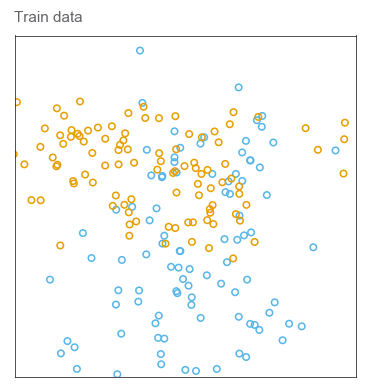

In [6]:
_, _ = plot_train_data('Train data')

In [7]:
# given prediction function calculates X points on n x n grid
# and corresponding predicted classes for ploting background dots
def predict_grid(n, predict_function):
    vals = np.linspace(-2, 3, n)
    X = np.transpose([np.tile(vals, n), np.repeat(vals, n)])
    y = predict_function(X)
    return X, y

# given prediction function calculates X0 and X1 n x n meshgrids
# and corresponing predicted classes meshgrid for plotting decision boundary
def predict_meshgrid(n, predict_function):
    X, y = predict_grid(n, predict_function)
    return X[:,0].reshape(n, n), X[:,1].reshape(n, n), y.reshape(n, n)

# plots train data, model decision bounary (by it's predict function) 
# and background points
def plot_model(predict_function, title):
    fig, ax1 = plot_train_data(title)
    # plot background dots
    X, y = predict_grid(81, predict_function)
    ax1.scatter(X[:,0], X[:,1], marker='.', lw=0, s=2, 
                c=np.array([BLUE, ORANGE])[y])
    # plot decision boundary
    X0, X1, Y = predict_meshgrid(1000, predict_function)
    ax1.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax1

<h2>Calculate Bayes Error and the Optimal Bayes Decision Boundary</h2>

In [8]:
# having known all means and convariances we build an optimal Bayes classifier
def optimal_bayes_predict(X):
    cov = np.eye(2)/5
    # convert means to frozen random variables for pdf calculation
    blue_rvs = [multivariate_normal(blue_means[i], cov) for i in range(10)]
    brown_rvs = [multivariate_normal(brown_means[i], cov) for i in range(10)]
    p_blue = np.sum(np.array([rv.pdf(X) for rv in blue_rvs]), axis=0)
    p_brown = np.sum(np.array([rv.pdf(X) for rv in brown_rvs]), axis=0)
    y_hat = 1*(p_brown>p_blue)
    return y_hat

In [9]:
# calculate the optimal Bayes error rate on the test data
bayes_error_rate = mean_absolute_error(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2225


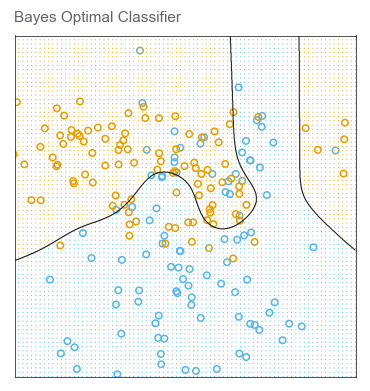

In [10]:
# test prepare_model_plot for the optimal Bayes
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

<h2>More Plotting Functions</h2>

In [11]:
# save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = predict_meshgrid(1000, optimal_bayes_predict)

# plot model with background Bayes optimal decision boundary and stat
def plot_model_detailed(predict_function, title):
    fig, ax1 = plot_model(predict_function, title)
    ax1.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple', 
                linewidths=[0.5], linestyles='dashed')
    test_error_rate = mean_absolute_error(y_test, predict_function(X_test))
    train_error_rate = mean_absolute_error(y_train, predict_function(X_train))    
    parms = {'color': GRAY1, 
             'fontsize': 8, 
             'bbox': {'facecolor': 'white', 'pad': 5, 'edgecolor': 'none'}}
    l1 = f'Training Error: {train_error_rate:.3f}'
    l2 = f'Test Error:       {test_error_rate:.3f}'
    l3 = f'Bayes Error:    {bayes_error_rate:.3f}'
    ax1.text(-1.85, -1.35, l1, **parms)
    ax1.text(-1.85, -1.60, l2, **parms)
    ax1.text(-1.85, -1.85, l3, **parms)
    return fig, ax1    

<h2>Linear Regression</h2>

In [12]:
from sklearn.linear_model import LinearRegression

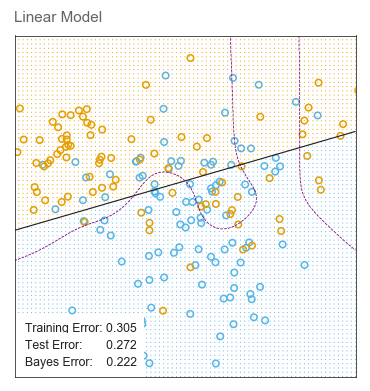

In [13]:
# PAGE 12. Let’s look at an example of the linear model in a classiﬁcation context. 
reg = LinearRegression().fit(X_train, y_train)

# PAGE 12. The ﬁtted values Y-hat are converted to a ﬁtted class variable G-hat according to the rule
#          G-hat =(ORANGE if Y-hat > 0.5, BLUE if Y-hat ≤ 0.5.
def linear_predict(X):
    return 1*(reg.predict(X)>0.5)

# PAGE 13. The line is the decision boundary deﬁned by x.T @ b = 0.5. The orange shaded region denotes
#          that part of input space classiﬁed as ORANGE, while the blue region is classiﬁed as BLUE. 
_, _ = plot_model_detailed(linear_predict, 'Linear Model')

<h2>Nearest-Neighbor Methods</h2>

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
# use GridSearchCV to find best parameter n_neighbors 
# through 10-folds cross-validation 
# will not use this value to be consistent with the book
parameters = {'n_neighbors': list(range(1, 50))}
knc = KNeighborsClassifier(n_neighbors=1)
grid = GridSearchCV(knc, parameters, cv=10)
grid.fit(X_train, y_train)
# sometimes it equals to 15
grid.best_params_

{'n_neighbors': 14}

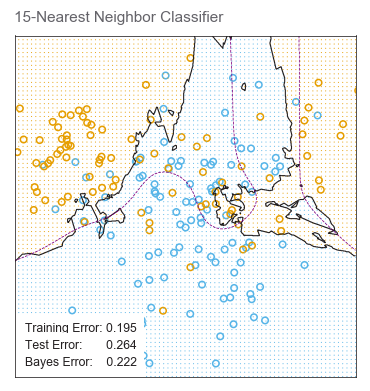

In [16]:
# PAGE 14. use 15-nearest-neighbor averaging of the binary coded response as the method of ﬁtting. 
#          Thus Y-hat is the proportion of ORANGE’s in the neighborhood, and so assigning class ORANGE 
#          to G-hat if Y-hat > 0.5 amounts to a majority vote in the neighborhood.
knc = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
_, _ = plot_model_detailed(knc.predict, '15-Nearest Neighbor Classifier')

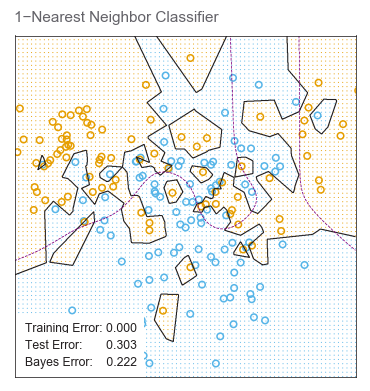

In [17]:
# PAGE 16. The classes are coded as a binary variable (BLUE = 0,ORANGE = 1), 
#          and then predicted by 1-nearest-neighbor classiﬁcation.
knc = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
_, _ = plot_model_detailed(knc.predict, '1−Nearest Neighbor Classifier')

<h2>Logistic Regression with Natural Cubic Spline Basis Expansion</h2>
NOTES: We use LogisticRegression from sklearn.linear_model. It is regularized version. As far as I understand, setting C to a relatively high value should eliminate the effect of penalties and, therefore, reduce the training error and increase the test error. Unfortunately, this is not the case. Regularized version gives better training error. Something I understand is wrong. Perhaps this is due to the fact that non-penalized logistic regression is not a strictly convex optimization problem. Perhaps this is due to the fact that binary crossentropy is not equivalent to mean absolute error. Must be studied further.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
# sklearn doesn't have natural cubic spline basis expansion
# so, let's implement it with fit-transform method to be used
# in pipeline
class NaturalCubicSplineFeatures():
    def __init__(self, knots, tensor_product=False):
        self.knots = knots
        self.tensor_product=tensor_product
    
    @staticmethod
    def dk(x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)
    
    @staticmethod
    def do_nc_expansion(x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)))
        for i in range(X.shape[0]):
            X[i, 0] = 1
            X[i, 1] = x[i]
            for k in range(2, len(xis)):
                X[i, k] = NaturalCubicSplineFeatures.dk(x[i], xis[k-2], xis[-1]) - \
                          NaturalCubicSplineFeatures.dk(x[i], xis[-2], xis[-1])
        return X
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        h = []
        for i in range(X.shape[1]):
            h.append(NaturalCubicSplineFeatures.do_nc_expansion(X[:,i], self.knots[i])[:,1:])            
        if self.tensor_product:
            for j in range(h[0].shape[1]):
                for k in range(h[1].shape[1]):
                    h.append(h[0][:,j:j+1]*h[1][:,k:k+1])
        result = np.hstack(h)
        return result

In [20]:
# the book doesn't give knots positions
knots = np.array([-2, 0, 1, 3])

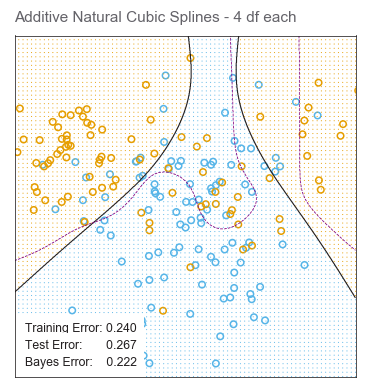

In [21]:
# PAGE 164. The upper panel shows the decision boundary of an additive 
#           logistic regression model, using natural splines in each 
#           of the two coordinates (total df = 1 + (4−1) + (4−1) = 7).
model = Pipeline([('expand', NaturalCubicSplineFeatures([knots, knots], 
                                                      tensor_product=False)),
                  ('scale', StandardScaler()),
                  ('logistic', LogisticRegression(solver='lbfgs'))])
lrc = model.fit(X_train, y_train)
_, _ = plot_model_detailed(lrc.predict, 'Additive Natural Cubic Splines - 4 df each')

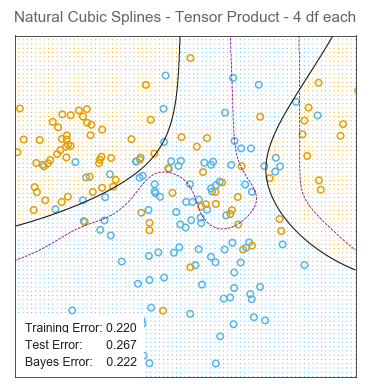

In [22]:
# PAGE 164. The lower panel shows the results of using a tensor product 
#           of natural spline bases in each coordinate (total df = 4 × 4 = 16).
model = Pipeline([('expand', NaturalCubicSplineFeatures([knots, knots], 
                                                      tensor_product=True)),
                  ('scale', StandardScaler()),
                  ('logistic', LogisticRegression(solver='lbfgs'))])
lrc = model.fit(X_train, y_train)
_, _ = plot_model_detailed(lrc.predict, 'Natural Cubic Splines - Tensor Product - 4 df each')

<h2>Neural Networks</h2>

In [23]:
import tensorflow as tf
import math
from sklearn.preprocessing import OneHotEncoder

C:\Python64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [24]:
# PAGE 398. Since the scaling of the inputs determines the eﬀective scaling of the 
#           weights in the bottom layer, it can have a large eﬀect on the quality of the ﬁnal
#           solution. At the outset it is best to standardize all inputs to have mean 
#           zero and standard deviation one. This ensures all inputs are treated equally 
#           in the regularization process, and allows one to choose a meaningful range for 
#           the random starting weights.
scaler = StandardScaler().fit(X_train)
X_train_standartized = scaler.transform(X_train)

# PAGE 392. For K-class classiﬁcation, there are K units at the top, with the kth unit modeling 
#           the probability of class k. There are K target measurements Yk, k = 1,...,K, each 
#           being coded as a 0−1 variable for the kth class.
Y_train_one_hot = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1, 1)).toarray()

In [25]:
session = tf.Session()

In [26]:
n_hidden = 10
initializer = tf.contrib.layers.xavier_initializer()

x = tf.placeholder(tf.float64, shape=[None, 2])
y = tf.placeholder(tf.float64, shape=[None, 2])

A = tf.Variable(initializer([2, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 2], dtype=tf.float64))
b0 = tf.Variable(initializer([2], dtype=tf.float64))

# PAGE 392. Derived features Zm are created from linear combinations of the inputs, 
#           and then the target Yk is modeled as a function of linear combinations of the Zm, 
#           The activation function σ(v) is usually chosen to be the sigmoid σ(v) = 1/(1+e−v);
Z = tf.nn.sigmoid(a0 + x@A)
T = b0 + Z@B

# PAGE 393. The output function gk(T) allows a ﬁnal transformation of the vector of outputs T. 
#           For regression we typically choose the identity function gk(T) = Tk. 
#           Early work in K-class classiﬁcation also used the identity function, but this was 
#           later abandoned in favor of the softmax function
y_hat = tf.nn.softmax(T)

# PAGE 395. For classiﬁcation we use either squared error or cross-entropy (deviance)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
feed_dict = {x: X_train_standartized, 
             y: Y_train_one_hot}

In [28]:
# PAGE 395. The generic approach to minimizing R(θ) is by gradient descent, 
#           called back-propagation in this setting. Because of the compositional 
#           form of the model, the gradient can be easily derived using the chain rule 
#           for diﬀerentiation. This can be computed by a forward and backward sweep 
#           over the network, keeping track only of quantities local to each unit.
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

# PAGE 395. Typically we don’t want the global minimizer of R(θ), 
#           as this is likely to be an overﬁt solution. Instead some regularization 
#           is needed: this is achieved directly through a penalty term, 
#           or indirectly by early stopping.
admW = tf.contrib.opt.AdamWOptimizer(0.003, learning_rate=1e-2).minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [29]:
# let's write a generic training procedure 
def train_and_plot(optimizer_step, title):
    session.run(tf.global_variables_initializer())
    step = 0
    # calc initial loss
    current_loss = session.run(loss, feed_dict)
    while step < 100000:
        step += 1
        if math.log(step, 5).is_integer():
            print(f'step: {step}, current loss: {current_loss}')
        session.run(optimizer_step, feed_dict)
        current_loss = session.run(loss, feed_dict)
    print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')
    
    def nn_predict(X):
        X = scaler.transform(X)
        # PAGE 395. and the corresponding classiﬁer is G(x) = argmaxkfk(x)
        return np.argmax(session.run(y_hat, {x: X}), axis=1)
    _, _ = plot_model_detailed(nn_predict, title)

step: 1, current loss: 0.9676180569853702
step: 5, current loss: 0.8079688084269355
step: 25, current loss: 0.6198804404167793
step: 625, current loss: 0.44556425598164495
step: 3125, current loss: 0.35500199491594314
step: 78125, current loss: 0.2925775357744568
ENDED ON STEP: 100000, FINAL LOSS: 0.29242999713307916
step: 1, current loss: 0.641014539478482
step: 5, current loss: 0.6140132847188018
step: 25, current loss: 0.5504192591419103
step: 625, current loss: 0.4463892878274664
step: 3125, current loss: 0.4322740417548679
step: 78125, current loss: 0.40177583657986093
ENDED ON STEP: 100000, FINAL LOSS: 0.403925064011309


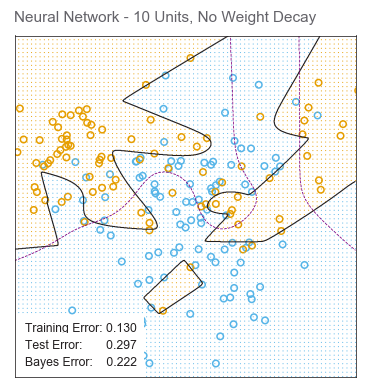

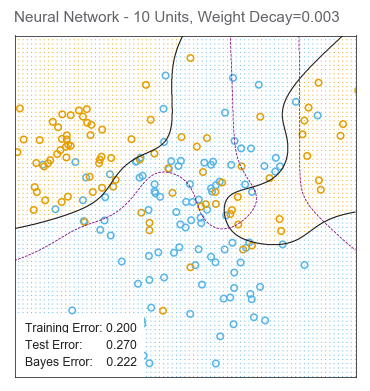

In [30]:
# PAGE 399. A neural network on the mixture example of Chapter 2. 
#           The upper panel uses no weight decay, and overﬁts the training data. 
#           The lower panel uses weight decay, and achieves close to the Bayes error rate 
#           (broken purple boundary). Both use the softmax activation function and 
#           cross-entropy error.
train_and_plot(adm, 'Neural Network - 10 Units, No Weight Decay')
train_and_plot(admW, 'Neural Network - 10 Units, Weight Decay=0.003')

<h2>Logistic Regression Through Neural Network (Not From the Book)</h2>

In [31]:
X_train_standartized = NaturalCubicSplineFeatures([knots, knots], 
                                              tensor_product=True).fit(X_train).transform(X_train)
Y_train_one_hot = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1, 1)).toarray()
p = X_train_standartized.shape[1]

session = tf.Session()

initializer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float64, shape=[None, p])
y = tf.placeholder(tf.float64, shape=[None, 2])

# variables to be optimized with initial guess
A = tf.Variable(initializer([p, 2], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 2], dtype=tf.float64))
y_hat = tf.nn.softmax(a0 + x@A)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))

In [32]:
feed_dict = {x: X_train_standartized, 
             y: Y_train_one_hot}
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)
session.run(tf.global_variables_initializer())

In [33]:
step = 0
current_loss = session.run(loss, feed_dict)
while step < 100000:
    step += 1
    if math.log(step, 5).is_integer():
        print(f'step: {step}, current loss: {current_loss}')
    session.run(adm, feed_dict)
    current_loss = session.run(loss, feed_dict)
print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

step: 1, current loss: 2.538584663547469
step: 5, current loss: 1.868125311220466
step: 25, current loss: 0.9814402084148167
step: 625, current loss: 0.43656015754230215
step: 3125, current loss: 0.4275928023367876
step: 78125, current loss: 0.4144794413346584
ENDED ON STEP: 100000, FINAL LOSS: 0.41382577241651697


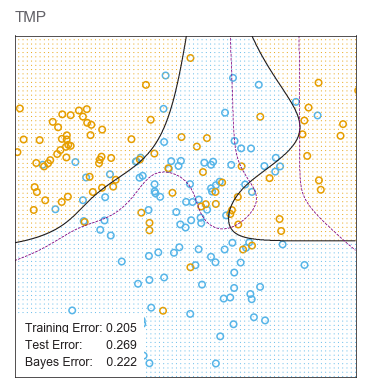

In [34]:
def nn_predict(X):
    X = NaturalCubicSplineFeatures([knots, knots], 
                                   tensor_product=True).fit(X).transform(X)
    #X = scaler.transform(X)
    return np.argmax(session.run(y_hat, {x: X}), axis=1)
_, _ = plot_model_detailed(nn_predict, 'TMP')

<h2>Support Vector Machines and Flexible Discriminants</h2>

In [13]:
from sklearn.svm import LinearSVC

C:\Python64\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


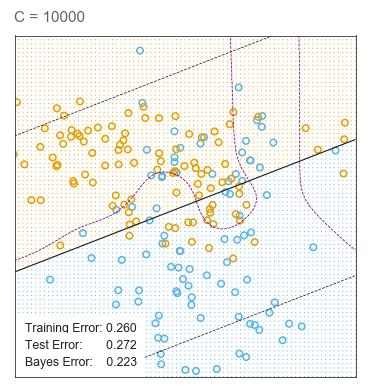

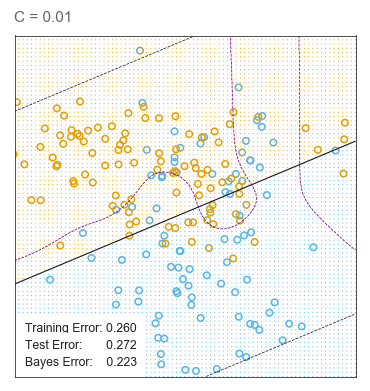

In [14]:
# PAGE 422. The linear support vector boundary for the mixture data example 
#           with two overlapping classes, for two diﬀerent values of C.
#           The broken lines indicate the margins, where f(x) = ±1. The support points (αi > 0) 
#           are all the points on the wrong side of their margin.
svc = LinearSVC(C=10000, max_iter=1000000)
svc.fit(X_train, y_train)
fig, ax = plot_model_detailed(svc.predict, 'C = 10000')
X0, X1, Y = predict_meshgrid(1000, svc.decision_function)
ax.contour(X0, X1, Y, [-1, 1], colors=GRAY1, linewidths=[0.5, 0.5], linestyles='dashed')

# PAGE 422. In the upper panel 62% of the observations are support points, while in the lower panel 85% are.
svc = LinearSVC(C=0.01, max_iter=1000000)
svc.fit(X_train, y_train)
fig, ax = plot_model_detailed(svc.predict, 'C = 0.01')
X0, X1, Y = predict_meshgrid(1000, svc.decision_function)
ax.contour(X0, X1, Y, [-1, 1], colors=GRAY1, linewidths=[0.5, 0.5], linestyles='dashed')

# PAGE 421.  The margin is larger for C = 0.01 than it is for C = 10,000. Hence larger values of 
#            C focus attention more on (correctly classiﬁed) points near the decision boundary, 
#            while smaller values involve data further away. Either way, misclassiﬁed points are 
#            given weight, no matter how far away. In this example the procedure is not very sensitive 
#            to choices of C, because of the rigidity of a linear boundary. 

In [15]:
from sklearn.svm import SVC

C:\Python64\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


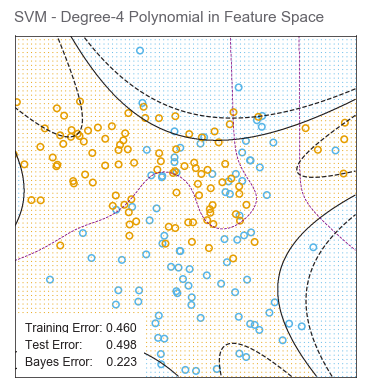

In [16]:
svc = SVC(kernel='poly', degree=4)
svc.fit(X_train, y_train)
fig, ax = plot_model_detailed(svc.predict, 'SVM - Degree-4 Polynomial in Feature Space')
X0, X1, Y = predict_meshgrid(1000, svc.decision_function)
ax.contour(X0, X1, Y, [-1, 1], colors=GRAY1, linewidths=[0.8, 0.8], linestyles='dashed')

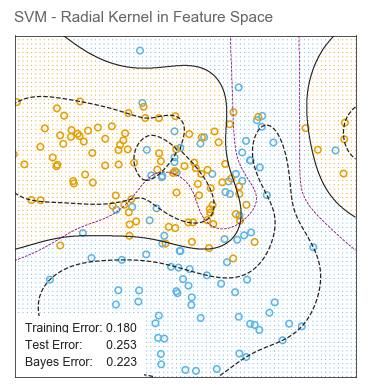

In [22]:
svc = SVC(kernel='rbf', gamma=1)
svc.fit(X_train, y_train)
fig, ax = plot_model_detailed(svc.predict, 'SVM - Radial Kernel in Feature Space')
X0, X1, Y = predict_meshgrid(1000, svc.decision_function)
ax.contour(X0, X1, Y, [-1, 1], colors=GRAY1, linewidths=[0.8, 0.8], linestyles='dashed')